# Simulate dropout smearing

Try to simulate a complex function f: R->R. Let a model train on it. Then shift the function up and use dropout. How good will it adapt? Will there be smearing?

In [73]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [74]:
x = np.linspace(0,10,1000, dtype=np.float32)
x


array([ 0.        ,  0.01001001,  0.02002002,  0.03003003,  0.04004004,
        0.05005005,  0.06006006,  0.07007007,  0.08008008,  0.09009009,
        0.1001001 ,  0.11011011,  0.12012012,  0.13013013,  0.14014015,
        0.15015015,  0.16016015,  0.17017017,  0.18018018,  0.1901902 ,
        0.2002002 ,  0.2102102 ,  0.22022022,  0.23023023,  0.24024025,
        0.25025025,  0.26026025,  0.27027026,  0.2802803 ,  0.2902903 ,
        0.3003003 ,  0.3103103 ,  0.3203203 ,  0.33033034,  0.34034035,
        0.35035035,  0.36036035,  0.37037036,  0.3803804 ,  0.3903904 ,
        0.4004004 ,  0.4104104 ,  0.4204204 ,  0.43043044,  0.44044045,
        0.45045045,  0.46046045,  0.47047046,  0.4804805 ,  0.4904905 ,
        0.5005005 ,  0.5105105 ,  0.5205205 ,  0.5305305 ,  0.5405405 ,
        0.5505506 ,  0.5605606 ,  0.5705706 ,  0.5805806 ,  0.5905906 ,
        0.6006006 ,  0.6106106 ,  0.6206206 ,  0.6306306 ,  0.6406406 ,
        0.6506507 ,  0.6606607 ,  0.6706707 ,  0.6806807 ,  0.69

In [75]:
f = lambda x: np.sin(x) + np.sin(x/7) + np.sin(x/5) - np.sin(x/3) + np.sin(9*x) * np.exp(-x ** 2) + 1.5 + np.random.normal(0,1e-2,x.shape)
y = f(x)


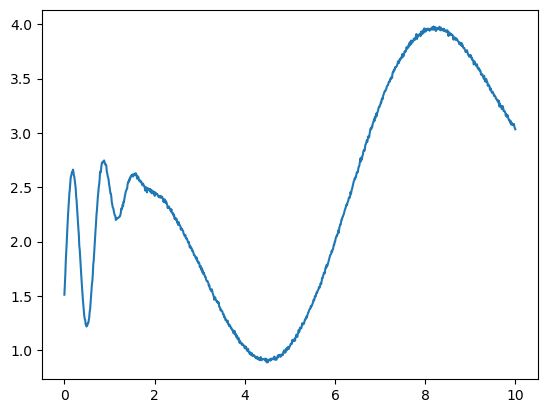

In [76]:
plt.plot(x,y)

In [77]:
from torch import nn
import torch

class LinearNet(nn.Module):
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.do = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.do(x)
        x = self.fc3(x)
        return x

In [78]:
from torch.utils.data import DataLoader,TensorDataset

train_mask = np.zeros([x.shape[0]],dtype=bool)
train_mask[:int(0.6*x.shape[0])] = 1
np.random.shuffle(train_mask)
test_mask = ~train_mask


train_set = TensorDataset(torch.from_numpy(x[train_mask]), torch.from_numpy(y[train_mask]))
train_loader = DataLoader(train_set, batch_size=16, shuffle=False)

test_set = TensorDataset(torch.from_numpy(x[test_mask]), torch.from_numpy(y[test_mask]))
test_dataloader= DataLoader(test_set, batch_size=16, shuffle=False)


In [79]:
dataloaders = {'train':train_loader,
               'eval':test_dataloader}

In [84]:
import time
class early_stopping_callback:
  def __init__(self,min_delta=0,patience=1):
    self.min_delta=min_delta
    self.patience=patience
    self.counter=0
    self.lowest_loss=np.inf
  def check_early_stopping(self,eval_loss):
    delta =  self.lowest_loss - eval_loss
    if delta >= self.min_delta:
      self.lowest_loss = eval_loss
      self.counter = 0
    else:
      self.counter += 1
      if counter >= patience:
        return True
    return False
  


    
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5, verbose = 0):
    since = time.time()
    if verbose > 0:
      modulo_coeff = 10
    else:
      modulo_coeff = 100

    patience = 10
    es_callback = early_stopping_callback(min_delta=0,patience=patience)

    val_acc_history = []
    for epoch in range(num_epochs):
        if epoch % modulo_coeff == 0:
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))

        ############ train phase ############
        phase = 'train'
        model.train()

        running_loss = 0.0
        # running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          optimizer.zero_grad()
          outputs = model(inputs.unsqueeze(1))
          loss = loss_fn(outputs, labels.unsqueeze(1).float())
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))

        ############ eval phase ############
        phase = 'eval'
        model.eval()

        running_loss = 0.0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs.unsqueeze(1))
            loss = loss_fn(outputs, labels.unsqueeze(1).float())

          running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        if es_callback.check_early_stopping(epoch_loss):
          print(f"Stopping early in epoch {epoch}")
          break

        if verbose > 0:
           print('{} Loss: {:.4f}'.format(phase, epoch_loss))  

        val_acc_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 1m 58s
Epoch 0/2999
Epoch 100/2999
Epoch 200/2999
Epoch 300/2999
Epoch 400/2999
Epoch 500/2999
Epoch 600/2999
Epoch 700/2999
Epoch 800/2999
Epoch 900/2999
Epoch 1000/2999
Epoch 1100/2999
Epoch 1200/2999
Epoch 1300/2999
Epoch 1400/2999
Epoch 1500/2999
Epoch 1600/2999
Epoch 1700/2999
Epoch 1800/2999
Epoch 1900/2999
Epoch 2000/2999
Epoch 2100/2999
Epoch 2200/2999
Epoch 2300/2999
Epoch 2400/2999
Epoch 2500/2999
Epoch 2600/2999
Epoch 2700/2999
Epoch 2800/2999
Epoch 2900/2999
Training complete in 2m 10s
Epoch 0/

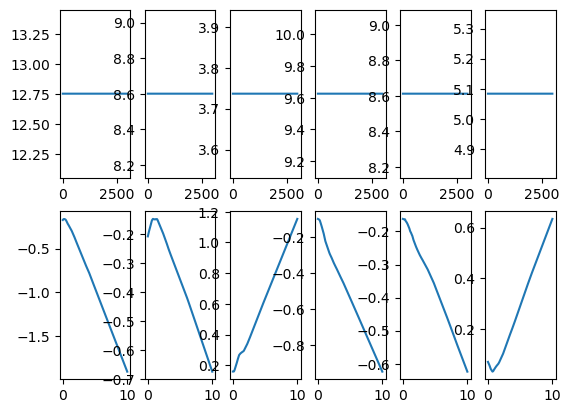

In [85]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
loss_fn = nn.MSELoss()
dropout_list = [0, 0.2, 0.4, 0.6, 0.8, 0.9]

fig, axs = plt.subplots(2, len(dropout_list))

for idx, dropout_prob in enumerate(dropout_list):
    optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)
    model = LinearNet(dropout_prob)
    hist = train_model(model,
                    dataloaders,
                    loss_fn,
                    optimizer,
                    num_epochs=3000
                    )

    axs[0,idx].plot(hist)
    axs[1,idx].plot(x,model(torch.from_numpy(x).unsqueeze(1)).detach().numpy())

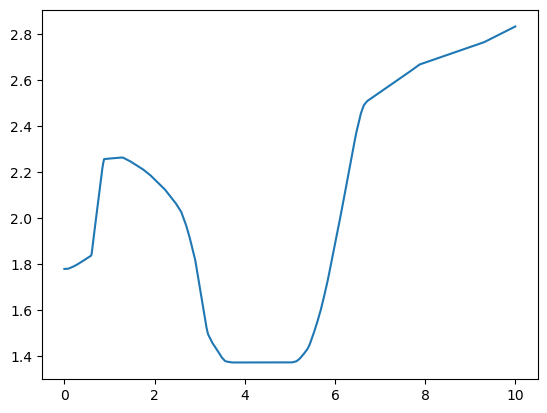

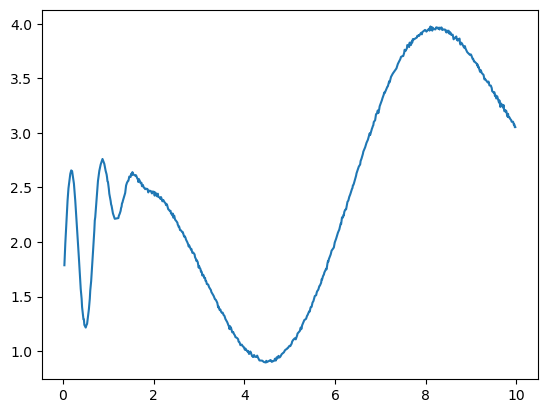

In [43]:
plt.plot(x[train_mask],y[train_mask])

# Getting event data from tfevents

Extract pd from log file

In [1]:
import traceback
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Extraction function
def tflog2pandas(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


In [2]:
def pivot_df(df):
    df_pivot = df.pivot(index = "step", columns = "metric", values = ["value"])
    df_pivot = df_pivot.droplevel(level=0,axis=1)
    df_pivot.columns.name = None
    return df_pivot
    

In [4]:
import os
import fnmatch
import json

for path,dirs,files in os.walk("G:\\Meine Ablage\\Masterarbeit\\fantastic-umbrella\\finished_runs\\04_mod_runs"):
    for file in fnmatch.filter(files,'run_overview.json'):
        df = tflog2pandas(path + "\\glue_no_trainer")
        df = pivot_df(df)
        df.index = df.index.astype("int")
        df.epoch = df.epoch.astype("int")
        df.to_csv(path + "\\tensorboard_data.csv")

        
        file_path = os.path.abspath(os.path.join(path,file))
        print(f'Found file at: {file_path}')
        with open(file_path, 'r') as f:
            d = json.load(f)

        if "accuracy" in df.columns:
            d["max_acc"] = df["accuracy"].max()
        else:
            d["max_acc"] = None

        if "matthews_correlation" in df.columns:
            d["max_matthews"] = df["matthews_correlation"].max()
        else:
            d["max_matthews"] = None
             
        
        d["min_evalLoss"] = df["eval_loss"].min()
        d["min_evalLoss_step"] = int(df["eval_loss"].idxmin())
        d["min_evalLoss_epoch"] = int(df.loc[d["min_evalLoss_step"],"epoch"])

        d["min_trainLoss"] = df["train_loss"].min()
        d["min_trainLoss_step"] = int(df["train_loss"].idxmin())
        d["min_trainLoss_epoch"] = int(df.loc[d["min_trainLoss_step"],"epoch"])
        
        new_file_path = os.path.abspath(os.path.join(path,'run_overview_extended.json'))
        with open(new_file_path, 'w') as f:
            json.dump(d,f)

Found file at: G:\Meine Ablage\Masterarbeit\fantastic-umbrella\finished_runs\04_mod_runs\run_modded_357_\run_overview.json
